In [55]:
pip install wfdb

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [57]:
import os

In [58]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [59]:
path='/kaggle/input/ecg-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [60]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [61]:
Y.scp_codes.shape

(21799,)

In [62]:
X = load_raw_data(Y, sampling_rate, path)

In [63]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [64]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [65]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [66]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [67]:
X_train.shape

(19601, 1000, 12)

In [68]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [69]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [70]:
np.unique(y_train).shape[0]

22

In [71]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [72]:
y_train_encoded.shape

(19601, 5)

In [73]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [74]:
type(y_train_encoded)

pandas.core.frame.DataFrame

In [75]:
y_train_encoded['final_output']=y_train_encoded.apply(lambda x:''.join(x.astype(str)),axis=1)

In [76]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,00010
1,0,0,0,1,0,00010
2,0,0,0,1,0,00010
3,0,0,0,1,0,00010
4,0,0,0,1,0,00010


In [77]:
y_train_encoded['final_output'].nunique()

22

In [78]:
y_train_encoded['final_output'].unique()

array(['00010', '00100', '00000', '00001', '01000', '10000', '00101',
       '11000', '10100', '10001', '01100', '01101', '01001', '10101',
       '10010', '11101', '11001', '00011', '11100', '10011', '01010',
       '11110'], dtype=object)

In [79]:
def adjust_classes(y_train):
    var=y_train
    if var == '00010':
        var=0
    elif var == '00100':
        var =1
    elif var== '00000':
        var=2
    elif var=='00001':
        var =3
    elif var =='01000':
        var=4
    elif var=='10000':
        var =5
    elif var =='00101':
        var =6
    elif var =='11000':
        var=7
    elif var =='10100':
        var=8
    elif var=='10001':
        var =9
    elif var =='01100':
        var =10
    elif var =='01101':
        var =11
    elif var=='01001':
        var=21
    elif var =='10101':
        var=12
    elif var =='10010':
        var=13
    elif var=='11101':
        var=14
    elif var=='11001':
        var=15
    elif var =='00011':
        var=16
    elif var=='11100':
        var=17
    elif var=='10011':
        var=18
    elif var =='01010':
        var=19
    elif var=='11110':
        var=20
    return var

In [80]:
y_train_encoded['final_output']=y_train_encoded['final_output'].apply(adjust_classes)

In [81]:
y_train_encoded

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
19596,0,0,0,0,1,3
19597,0,0,0,1,0,0
19598,0,0,0,0,1,3
19599,0,0,0,1,0,0


In [82]:
y_train_encoded['final_output'].value_counts()

final_output
0     8157
1     2276
3     2158
5     1524
8     1164
21     708
6      538
4      479
9      433
2      371
13     362
11     320
7      273
12     202
15     186
10     166
14     140
17     112
16      24
18       5
19       2
20       1
Name: count, dtype: int64

In [83]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [84]:
x_train_normalization=X_train.reshape(-1,1000*12)

In [85]:
x_train=scaler.fit_transform(x_train_normalization)
x_train_normalized=x_train.reshape(19601,1000,12)

In [86]:
class_distribution_norm=y_train_encoded['NORM'].value_counts()

In [87]:
class_distribution_cd=y_train_encoded['CD'].value_counts()

In [88]:
class_distribution_hyp=y_train_encoded['HYP'].value_counts()

In [89]:
class_distribution_mi=y_train_encoded['MI'].value_counts()

In [90]:
class_distribution_sttc=y_train_encoded['STTC'].value_counts()

In [172]:
indices_0 = np.where(y_train_encoded['NORM'] == 0)[0] 
indices_1 = np.where(y_train_encoded['NORM'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)

In [173]:
x_train=x_train[:,:,1:2]
x_train.shape

(8000, 1000, 1)

In [174]:
y_train.shape

(8000,)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_163 (Conv1D)             │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_165         │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_124               │ (None, 499, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_164 (Conv1D)             │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_166         │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_125               │ (None, 248, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_165 (Conv1D)             │ (None, 246, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_167         │ (None, 246, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_126               │ (None, 123, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_25     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5870 - loss: 0.8365 - val_accuracy: 0.5086 - val_loss: 0.9015 - learning_rate: 0.0010
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7273 - loss: 0.5506 - val_accuracy: 0.5125 - val_loss: 0.8998 - learning_rate: 0.0010
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7480 - loss: 0.5308 - val_accuracy: 0.6414 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7646 - loss: 0.5012 - val_accuracy: 0.6898 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7814 - loss: 0.4798 - val_accuracy: 0.7211 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7858 - loss: 0.4722 - val_accuracy: 0.7852 - val_loss: 0.4928 - learning_rate: 0.0010
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7946 - loss: 

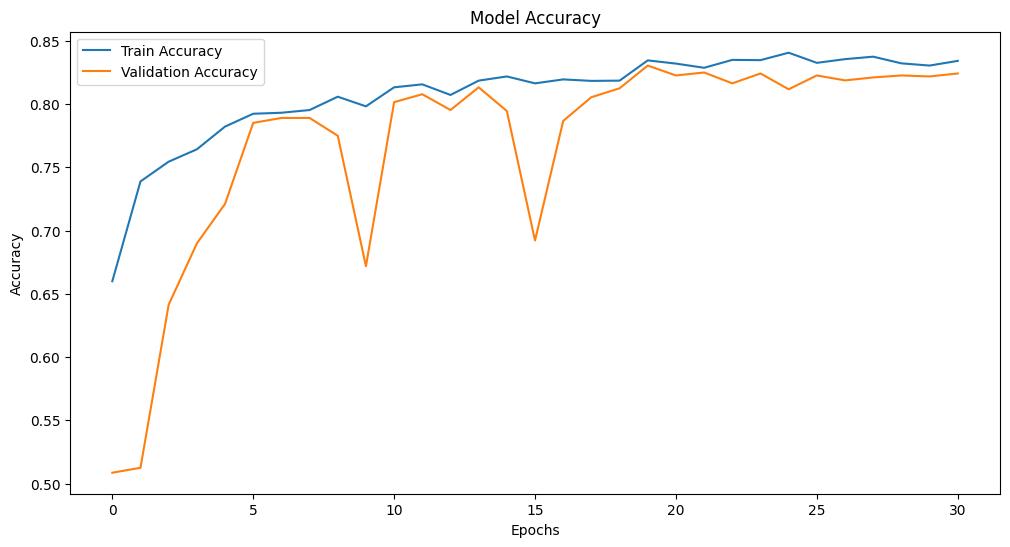

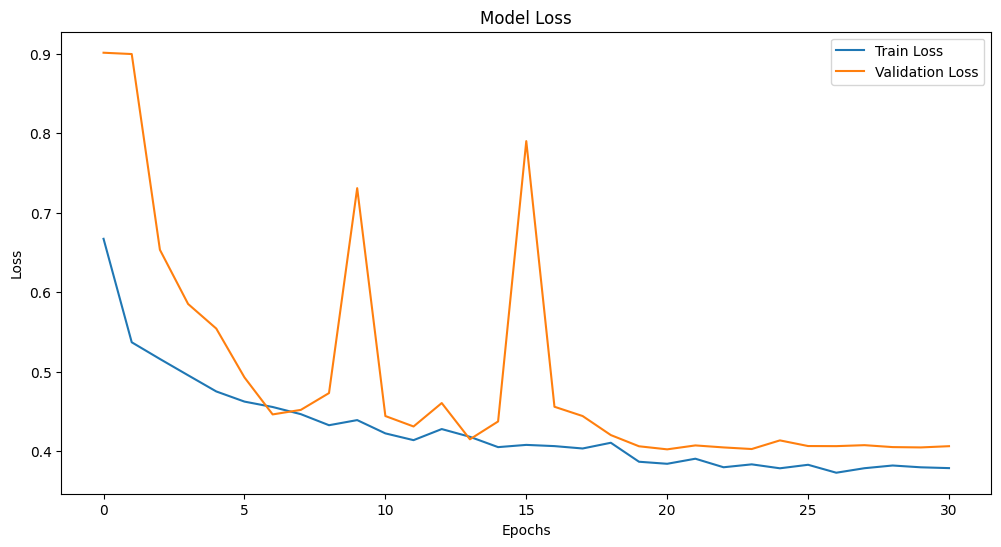

In [176]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train and y_train are your training data
# x_train: Shape (num_samples, 1000, 1), y_train: Shape (num_samples, num_classes)

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # For multi-class classification (adjust based on your class count)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Evaluate the model on test data (if available)
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_169 (Conv1D)             │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_171         │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_130               │ (None, 499, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_170 (Conv1D)             │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_172         │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_131               │ (None, 248, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_171 (Conv1D)             │ (None, 246, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_173         │ (None, 246, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_132               │ (None, 123, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_26     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6036 - loss: 0.8610 - val_accuracy: 0.0012 - val_loss: 1.8186 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7227 - loss: 0.5327 - val_accuracy: 0.0012 - val_loss: 2.3079 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7422 - loss: 0.4996 - val_accuracy: 0.0012 - val_loss: 2.5582 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7553 - loss: 0.4921 - val_accuracy: 0.0237 - val_loss: 1.3463 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7565 - loss: 0.4724 - val_accuracy: 0.2350 - val_loss: 1.0235 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7773 - loss: 0.4533 - val_accuracy: 0.5000 - val_loss: 0.7347 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7773 - loss: 0

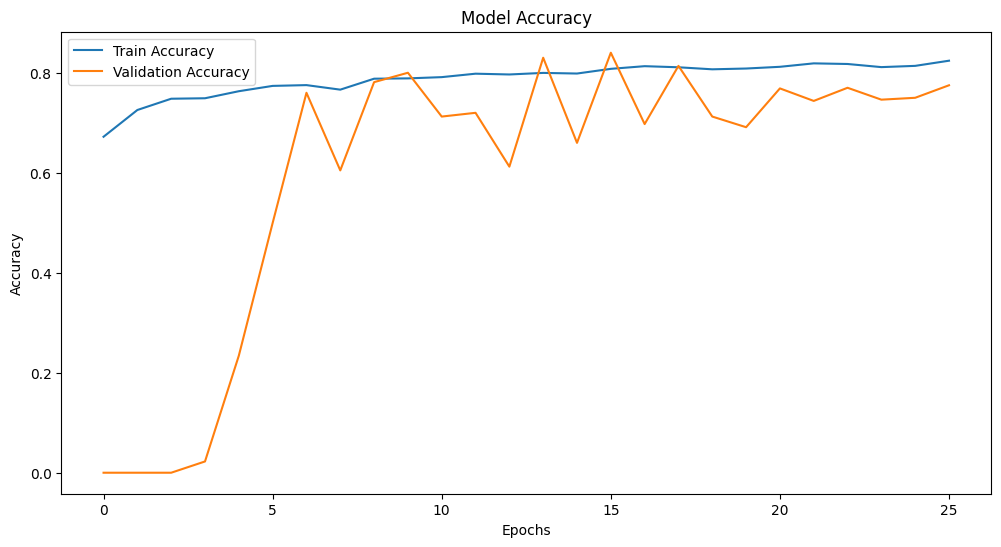

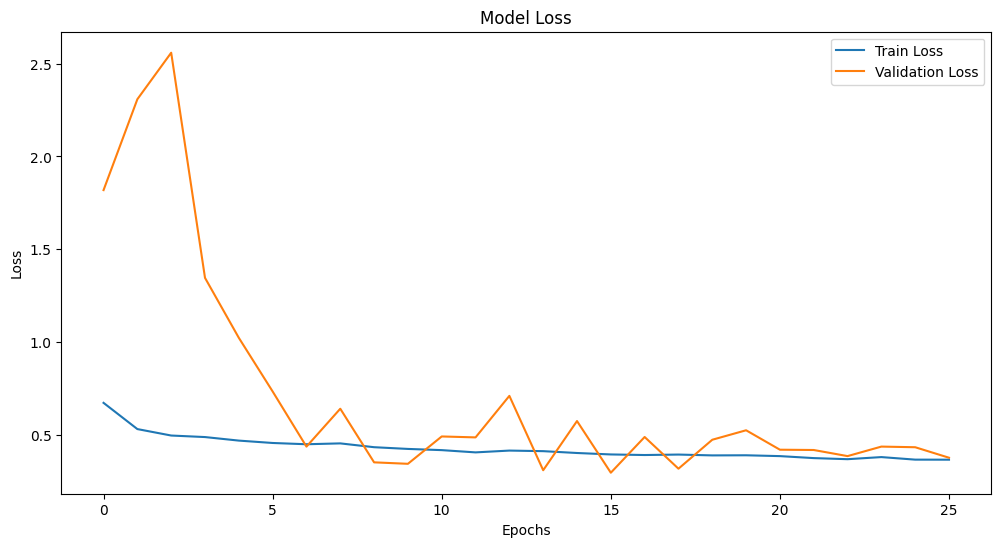

In [179]:
indices_0 = np.where(y_train_encoded['HYP'] == 0)[0] 
indices_1 = np.where(y_train_encoded['HYP'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 2000, replace=False)
selected_indices_1=np.random.choice(indices_1, 2000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train and y_train are your training data
# x_train: Shape (num_samples, 1000, 1), y_train: Shape (num_samples, num_classes)
x_train=x_train[:,:,1:2]

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # For multi-class classification (adjust based on your class count)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Evaluate the model on test data (if available)
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_175 (Conv1D)             │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_177         │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_136               │ (None, 499, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_176 (Conv1D)             │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_178         │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_137               │ (None, 248, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_177 (Conv1D)             │ (None, 246, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_179         │ (None, 246, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_138               │ (None, 123, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_28     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6278 - loss: 0.7690 - val_accuracy: 0.0044 - val_loss: 2.4690 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7331 - loss: 0.5309 - val_accuracy: 0.0181 - val_loss: 1.5613 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7543 - loss: 0.5035 - val_accuracy: 0.5238 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7567 - loss: 0.4897 - val_accuracy: 0.8831 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7912 - loss: 0.4515 - val_accuracy: 0.5713 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7913 - loss: 0.4519 - val_accuracy: 0.9425 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7880 - loss: 0

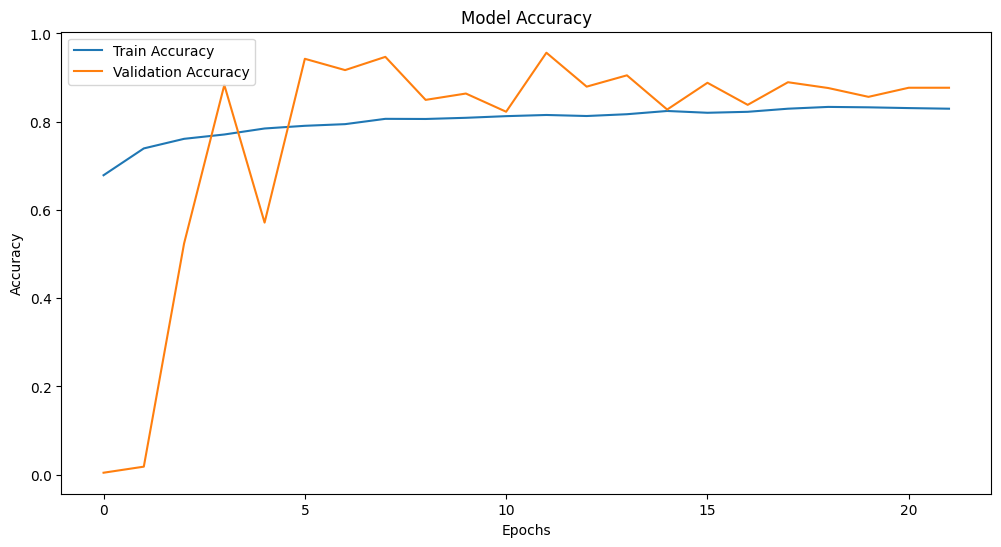

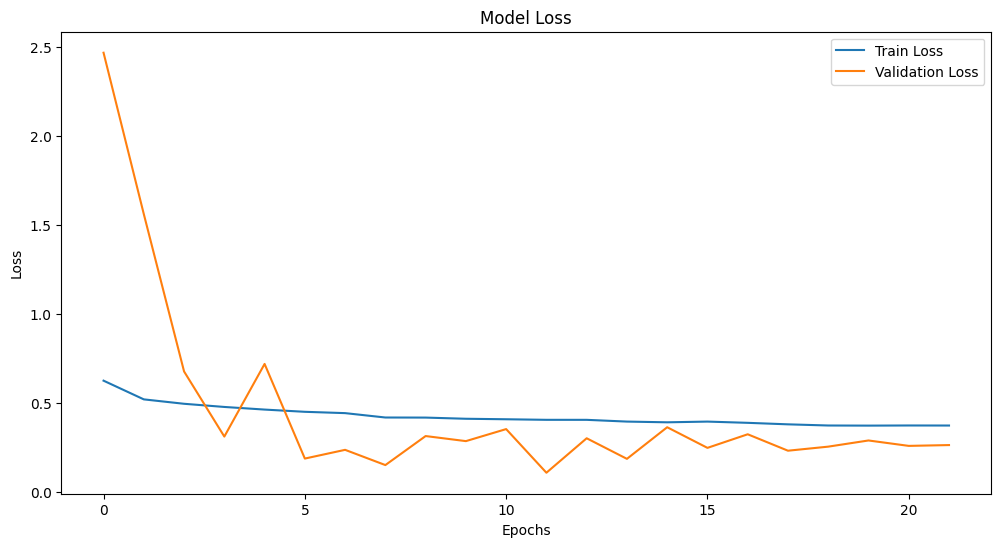

In [181]:

indices_0 = np.where(y_train_encoded['STTC'] == 0)[0] 
indices_1 = np.where(y_train_encoded['STTC'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train and y_train are your training data
# x_train: Shape (num_samples, 1000, 1), y_train: Shape (num_samples, num_classes)
x_train=x_train[:,:,1:2]

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # For multi-class classification (adjust based on your class count)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Evaluate the model on test data (if available)
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()



Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_178 (Conv1D)             │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_180         │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_139               │ (None, 499, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_179 (Conv1D)             │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_140               │ (None, 248, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_180 (Conv1D)             │ (None, 246, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_182         │ (None, 246, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_141               │ (None, 123, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_29     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6617 - loss: 0.7428 - val_accuracy: 0.0000e+00 - val_loss: 2.2774 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7374 - loss: 0.5203 - val_accuracy: 0.0000e+00 - val_loss: 2.2863 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7590 - loss: 0.4935 - val_accuracy: 0.1719 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7682 - loss: 0.4782 - val_accuracy: 0.7231 - val_loss: 0.5413 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7942 - loss: 0.4457 - val_accuracy: 0.7262 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7868 - loss: 0.4473 - val_accuracy: 0.7756 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7974 - 

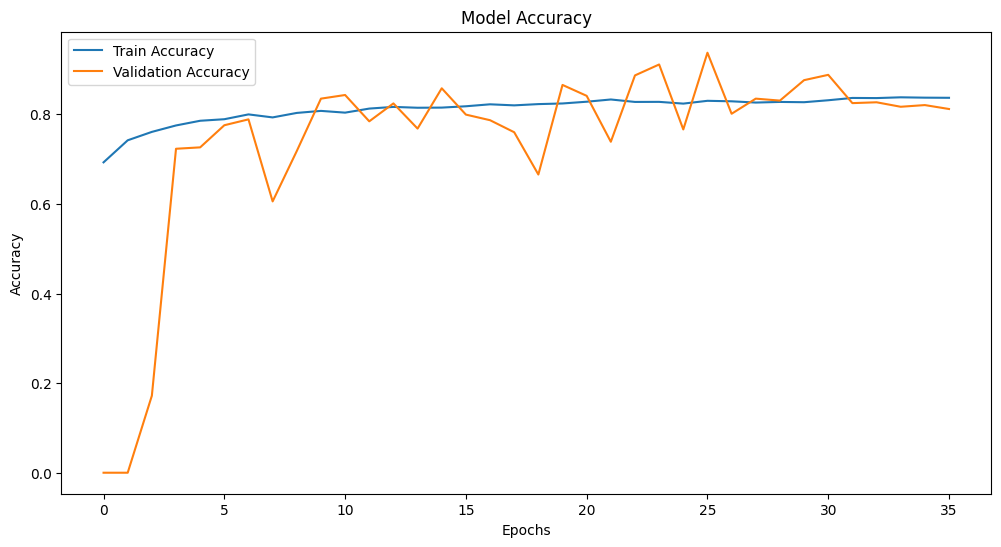

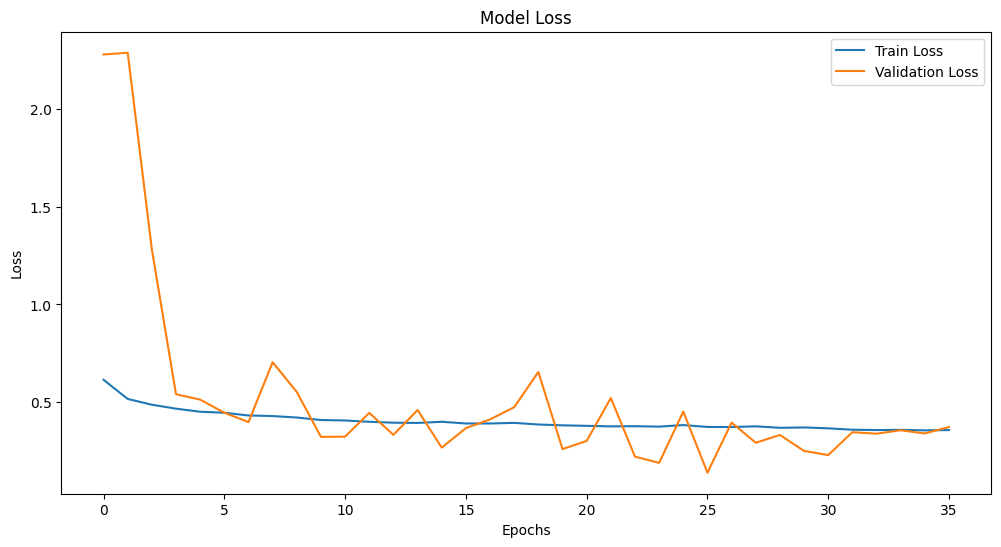

In [182]:

indices_0 = np.where(y_train_encoded['MI'] == 0)[0] 
indices_1 = np.where(y_train_encoded['MI'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train and y_train are your training data
# x_train: Shape (num_samples, 1000, 1), y_train: Shape (num_samples, num_classes)
x_train=x_train[:,:,1:2]

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # For multi-class classification (adjust based on your class count)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Evaluate the model on test data (if available)
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()



Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_181 (Conv1D)             │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_183         │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_142               │ (None, 499, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_182 (Conv1D)             │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_184         │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_143               │ (None, 248, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_183 (Conv1D)             │ (None, 246, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_185         │ (None, 246, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_144               │ (None, 123, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_30     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,093 (191.77 KB)

 Trainable params: 48,645 (190.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6514 - loss: 0.7372 - val_accuracy: 0.0900 - val_loss: 1.1747 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7489 - loss: 0.5086 - val_accuracy: 0.6612 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7587 - loss: 0.4784 - val_accuracy: 0.7331 - val_loss: 0.4961 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7712 - loss: 0.4716 - val_accuracy: 0.8238 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7929 - loss: 0.4376 - val_accuracy: 0.7475 - val_loss: 0.4648 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7938 - loss: 0.4359 - val_accuracy: 0.8238 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7879 - loss: 0.

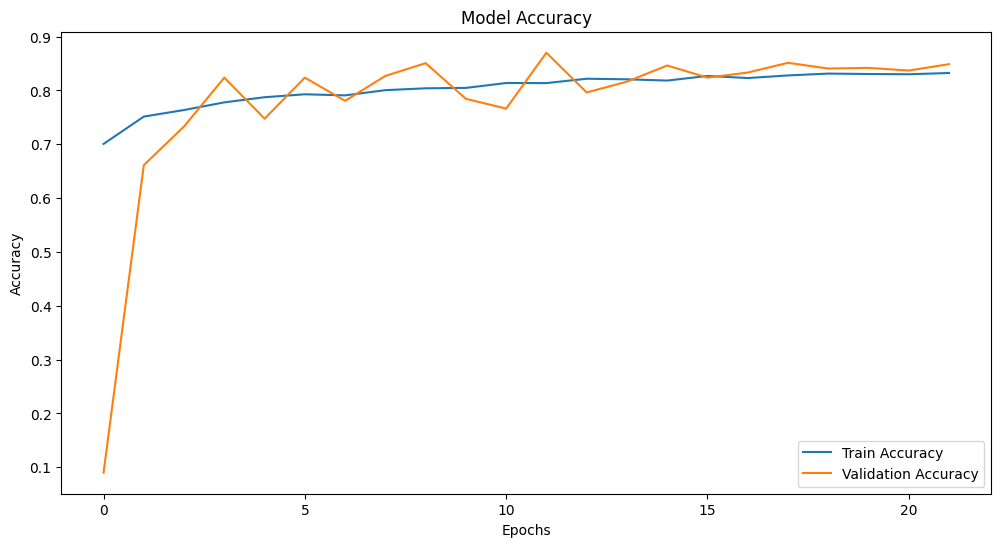

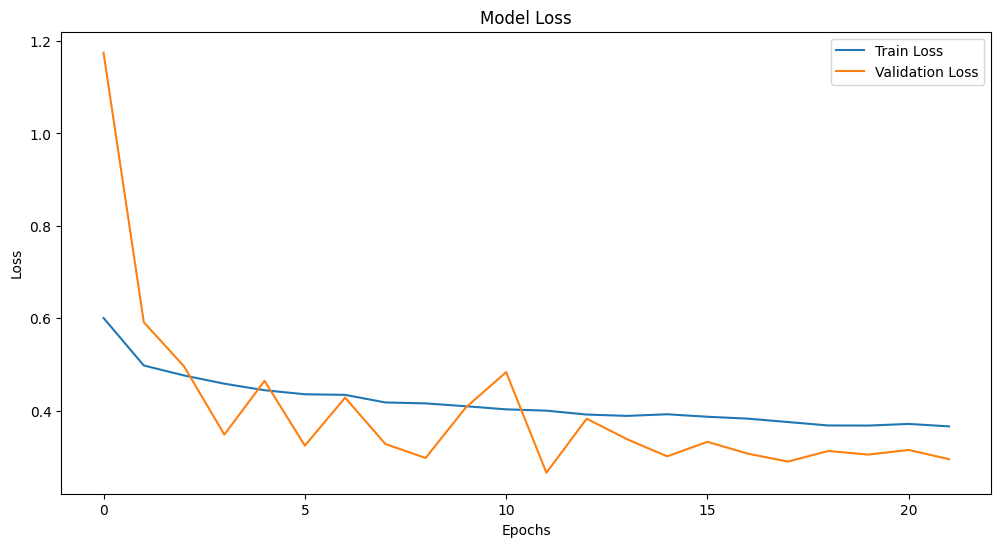

In [183]:

indices_0 = np.where(y_train_encoded['CD'] == 0)[0] 
indices_1 = np.where(y_train_encoded['CD'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming x_train and y_train are your training data
# x_train: Shape (num_samples, 1000, 1), y_train: Shape (num_samples, num_classes)
x_train=x_train[:,:,1:2]

# Define the model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Third convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Global Average Pooling to reduce dimensions and prevent overfitting
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer: Softmax for multi-class classification
model.add(Dense(5, activation='softmax'))  # For multi-class classification (adjust based on your class count)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting (monitoring validation loss)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the model stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary to inspect the architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,  # Use 20% of the data for validation
                    callbacks=[early_stopping, lr_scheduler])  # Early stopping and learning rate scheduler

# Evaluate the model on test data (if available)
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
# print(f"Validation Loss: {val_loss}")
# print(f"Validation Accuracy: {val_accuracy}")

# Plot training history (optional)
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

